# DDPM on MNIST

This repository is an small implementation of the pseudo algorithm of [Ho et al.](https://arxiv.org/abs/2006.11239) as shown in the following image: ![image](../images/ddpm_pseudocode.jpg)
Other helpful resource is the one of [Luo](https://arxiv.org/abs/2208.11970).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Device: cuda:0
xt_max = 3.492, xt_min = -3.435, xt_mean =  -0.003
x0_max = 2.821, x0_min = -0.424, x0_mean =  -0.006


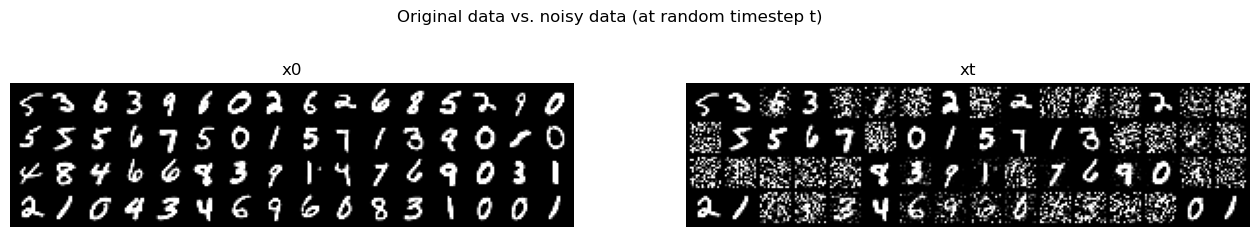

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# A LITTLE WORKING CONFIG:
# BATCH_SIZE    = 64
# IMG_SIZE      = 16
# INITIAL_LAYER = 64
# LEARNING_RATE = 2e-4

BATCH_SIZE    = 64
IMG_SIZE      = 16
INITIAL_LAYER = 32 # Matters alot! 32 okay, 48 failed, 64 best
LEARNING_RATE = 2e-4 # shouldnt matter too much as using RAdam
SCHEDULE      = "cosine" # matters alot!
# Using upscale instead of convetranspose matters!
# Minimal latent dimension matters!

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

def plot_noisy_pair(x0, xt):

    grid_x0 = make_grid(x0, nrow=16)
    grid_xt = make_grid(xt, nrow=16)

    fig, axes = plt.subplots(1, 2, figsize=(16, 3))

    axes[0].imshow(grid_x0.permute(1, 2, 0).cpu())
    axes[0].set_title('x0')
    axes[0].axis('off')

    axes[1].imshow(grid_xt.permute(1, 2, 0).cpu())
    axes[1].set_title('xt')
    axes[1].axis('off')

    plt.suptitle("Original data vs. noisy data (at random timestep t)")
    plt.show()

    return

transform = torchvision.transforms.transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_dataset = torchvision.datasets.MNIST('./../data', train=True, transform=transform, download=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = torchvision.datasets.MNIST('./../data', train=False, transform=transform, download=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

T = 1000
def linear_schedule(T, start=1e-4, end=0.02):
    beta_schedule = torch.linspace(start=start, end=end, steps=T)
    alpha_schedule = 1 - beta_schedule
    alpha_cumprod = alpha_schedule.cumprod(dim=0)
    return beta_schedule, alpha_schedule, alpha_cumprod

def cosine_beta_schedule(T, s=0.008):
    """Cosine schedule from annotated transformers.
    """
    steps = T + 1
    x = torch.linspace(0, T, steps)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    beta_schedule = torch.clip(betas, 0.0001, 0.9999)
    alpha_schedule = 1-beta_schedule
    return beta_schedule, alpha_schedule, alphas_cumprod

# Crucially better performance against linear
beta_schedule, alpha_schedule, alpha_cumprod = cosine_beta_schedule(T) if SCHEDULE == "cosine" else linear_schedule(T)

def preprocess(x0): 

    # Noise creation equivalent to DDPMs
    t = torch.randint(low=0, high=T, size=(x0.shape[0],))
    noise = torch.randn_like(x0)
    alpha = alpha_cumprod[t]
    xt = x0.clone()
    for j in range(xt.shape[0]):
        xt[j] = torch.sqrt(alpha[j]) * xt[j] + (1-alpha[j]) * noise[j] # in terms of x0

    return xt,t,noise, alpha

(x0, label) = next(iter(train_dataloader))
xt,t,noise,alpha = preprocess(x0)

print(f"xt_max = {xt.max():.3f}, xt_min = {xt.min():.3f}, xt_mean =  {xt.mean():.3f}")
print(f"x0_max = {x0.max():.3f}, x0_min = {x0.min():.3f}, x0_mean =  {x0.mean():.3f}")

plot_noisy_pair(x0, xt)

In [5]:
from denoising_diffusion_pytorch import Unet
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        # Upsample + conv2d --> less params + better performance
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        )
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class MinimalConditionedUNet(nn.Module):
    
    # model conditioned on noise in first layer
    # using embedding is not elegant because 
    # 1) we would need to pre-define the embedding size
    # (e.g. nn.Linear(1,x.width*x.height)) --> so the model could only work for one size
    # 2) a senseless learnable layer
    # instead, we just broadcast t into the respective shape in the forward pass 
    # (and we scale it to a range between [0,1] to keep things nice for the network)
    
    def __init__(self, n_channels, n_diffsteps, img_size, initial_layer=16):
        super(MinimalConditionedUNet, self).__init__()
        self.n_channels = n_channels
        self.n_diffsteps = n_diffsteps
        
        # Guarantee that smallest image size doesnt surpass min_latent_size --> better deep and small min_latent_size
        min_latent_size = 2 # minimal latent size of (2,2) 
        multiplications=[1,2,4,8] # Cannot be set from outside currently, needs to be multiplied by 2 all the time
        self.nfeatures = [initial_layer*m for i,m in enumerate(multiplications) if img_size//2**i >= min_latent_size] 
        
        self.first_layer = DoubleConv(n_channels + 1, self.nfeatures[0])
        
        self.down = nn.ModuleList()
        for i in range(len(self.nfeatures)-1):
            self.down.append(Down( self.nfeatures[i] + 1, self.nfeatures[i+1]))

        self.up = nn.ModuleList()
        for i in reversed(range(len(self.nfeatures)-1)):
            self.up.append(Up(self.nfeatures[i+1], self.nfeatures[i]))

        self.out = nn.Conv2d(self.nfeatures[0], self.n_channels, kernel_size=1)
        
    def forward(self, x, t):
        
        B,C,H,W = x.shape
        t = (t/self.n_diffsteps).clone()
        t0 = t.view(B,1,1,1).expand(B,1,H,W)
        x_cond = torch.cat([x,t0], dim=1)
        
        xi = []
        xi.append(self.first_layer(x_cond))

        for down_i in self.down:
            B,C,H,W = xi[-1].shape
            t1 = t.view(B,1,1,1).expand(B,1,H,W)
            x_cond = torch.cat([xi[-1],t1], dim=1)
            xi.append(down_i(x_cond))

        for i,up_i in enumerate(self.up):    
            x = up_i(xi[-1-i], xi[-2-i])
            pass

        out = self.out(x)
        return out
    

class Multiconv(nn.Module):
    
    # model conditioned on noise in first layer
    # using embedding is not elegant because 
    # 1) we would need to pre-define the embedding size
    # (e.g. nn.Linear(1,x.width*x.height)) --> so the model could only work for one size
    # 2) a senseless learnable layer
    # instead, we just broadcast t into the respective shape in the forward pass 
    # (and we scale it to a range between [0,1] to keep things nice for the network)
    
    def __init__(self, n_channels, n_diffsteps, initial_layer=4, multiplications=[1,2,4,8]):
        super(MinimalConditionedUNet, self).__init__()

        self.layers = nn.ModuleList()
        self.nfeatures = [initial_layer*m for i,m in enumerate(multiplications + reversed(multiplications[:-1]))]
    
    def forward(self, x, t):
        pass


model = MinimalConditionedUNet(n_channels=1, img_size=IMG_SIZE, initial_layer=INITIAL_LAYER, n_diffsteps=T).to(device)
# model = Unet(dim=IMG_SIZE, channels=1, self_condition=False)

# resume = False
# if resume==True:
#     model.load_state_dict(torch.load("ddpm.ckpt"))

# model = model.to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=LEARNING_RATE)
mse = torch.nn.MSELoss()

def train_one_epoch(epoch_number):

    model.train()
    running_loss = 0.0

    num_accumulated_losses = len(train_dataloader)//10

    for i, (batch, label) in enumerate(train_dataloader):

        if i >= (num_accumulated_losses)*10:
            break
        optimizer.zero_grad()

        xt,t,noise,alpha = preprocess(batch)
        xt,t,noise = xt.to(device), t.to(device), noise.to(device)

        # predict noise, given (xt[B,1,W,H],t[B])
        predicted_noise = model(xt,t)
        loss = mse(noise, predicted_noise)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()

        if i%num_accumulated_losses == num_accumulated_losses - 1:

            last_loss = running_loss / num_accumulated_losses
            print(f"Epoch: {epoch_number+1}, iteration: [{i +1} / {len(train_dataloader)}], loss: {running_loss/num_accumulated_losses:.5f}")
            running_loss = 0.0

    return last_loss

def validate():
    # Disable gradient computation and reduce memory consumption.
    model.eval()
    with torch.no_grad():
        running_vloss = 0.0
        for vdata in val_dataloader:
            batch, vlabels = vdata
            
            x0 = batch.to(device)
            xt,t,noise,alpha = preprocess(x0)
            xt,t,noise = xt.to(device), t.to(device), noise.to(device)

            prediction = model(xt,t)
            vloss = mse(prediction, noise)
            running_vloss += vloss

        return running_vloss / len(val_dataloader)
        

MAX_EPOCHS = 200
best_vloss = 1e6
patience = 2

for i in range(MAX_EPOCHS):

    model.train()
    training_loss = train_one_epoch(i)

    model.eval()
    validation_loss = validate()

    print(f'\nEPOCH {i+1} FINISHED\nLOSS train {training_loss} valid {validation_loss}\n')

    if training_loss < best_vloss:
        vloss_count = 0
        best_vloss = validation_loss
        model_path = 'ddpm_minimal.ckpt' # just saving best
        torch.save(model.state_dict(), model_path)
    else:
        vloss_count += 1
        if vloss_count == patience:
            print(f'Validation loss did not increase for {patience} epochs, keeping checkpoint of epoch {i-2+1}')
            break
    

Epoch: 1, iteration: [93 / 938], loss: 0.84415
Epoch: 1, iteration: [186 / 938], loss: 0.48593
Epoch: 1, iteration: [279 / 938], loss: 0.34962
Epoch: 1, iteration: [372 / 938], loss: 0.30340
Epoch: 1, iteration: [465 / 938], loss: 0.27104
Epoch: 1, iteration: [558 / 938], loss: 0.25996
Epoch: 1, iteration: [651 / 938], loss: 0.24532
Epoch: 1, iteration: [744 / 938], loss: 0.24052
Epoch: 1, iteration: [837 / 938], loss: 0.23056
Epoch: 1, iteration: [930 / 938], loss: 0.22211

EPOCH 1 FINISHED
LOSS train 0.22211110912343507 valid 0.22335977852344513

Epoch: 2, iteration: [93 / 938], loss: 0.22138
Epoch: 2, iteration: [186 / 938], loss: 0.21273
Epoch: 2, iteration: [279 / 938], loss: 0.21570
Epoch: 2, iteration: [372 / 938], loss: 0.21013


KeyboardInterrupt: 

### Sampling

If questions to the intuitions behind $\sigma^2_t$, check this [stack exchange link](https://stats.stackexchange.com/questions/605231/why-do-denoising-diffusion-probabilistic-models-ddpm-add-noise-according-to). Also check [Luo](https://arxiv.org/abs/2208.11970) for more detail. Here he writes (page 11): "Then, the form of q(xt|x0) can be recursively derived through repeated applications of the reparameterization  trick. Suppose that we have access to 2T random noise variables". So in my understanding they go back and (a little bit) forth again.

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


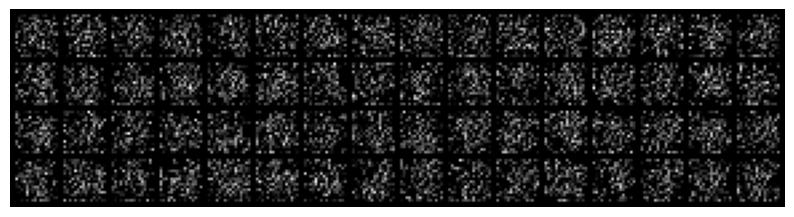

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


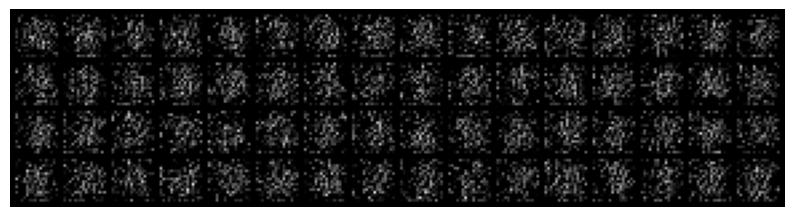

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


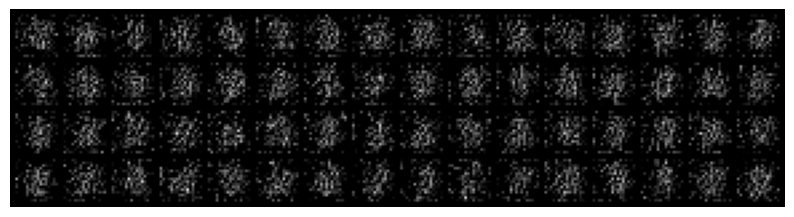

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


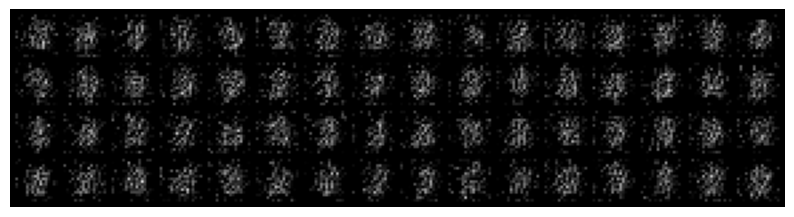

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


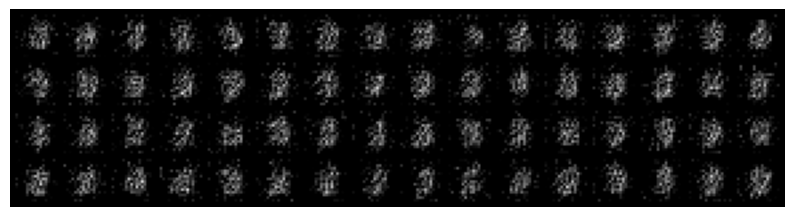

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


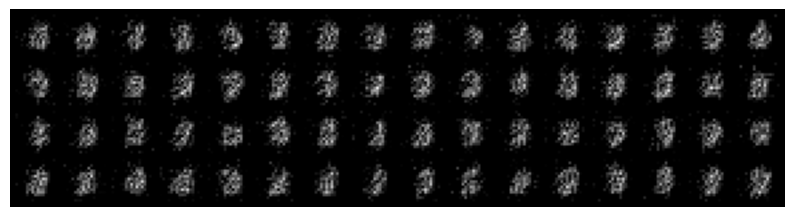

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


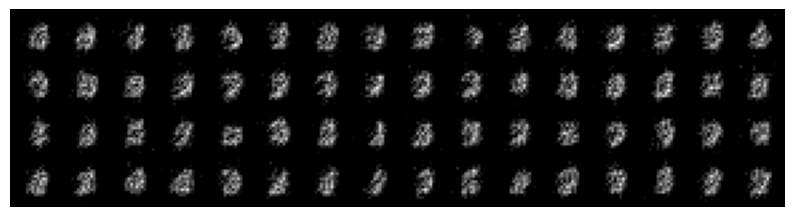

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


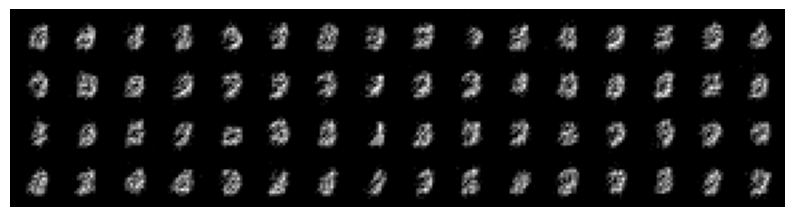

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


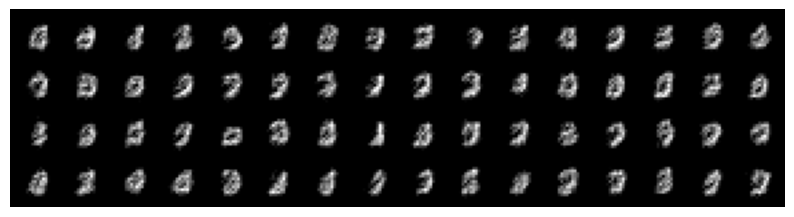

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


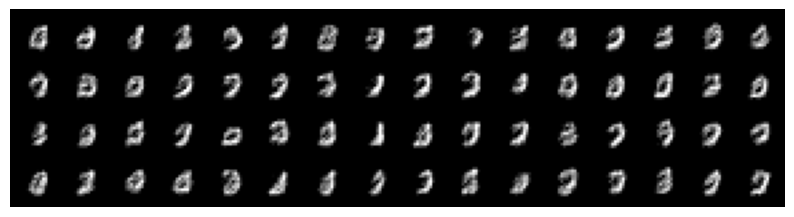

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


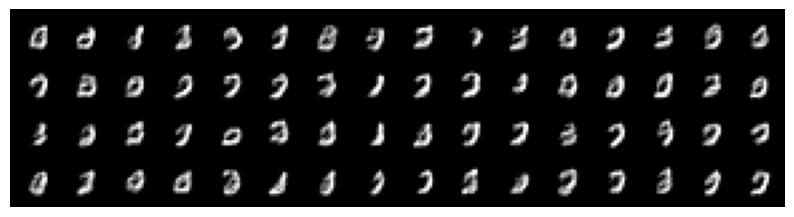

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


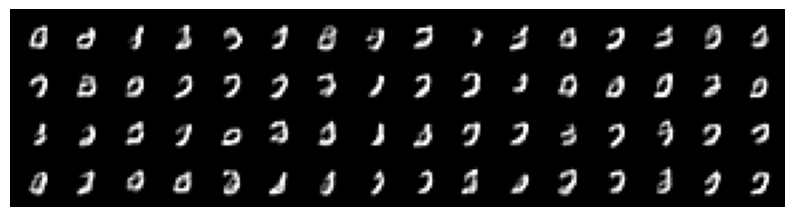

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


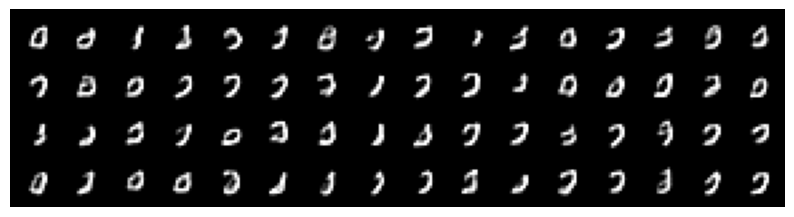

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


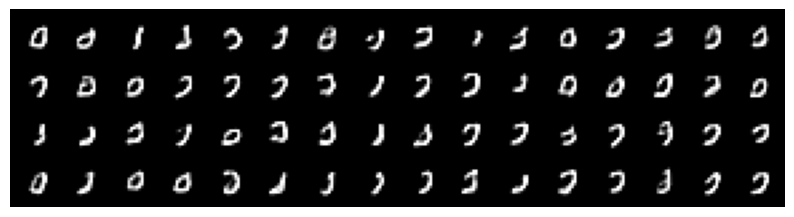

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


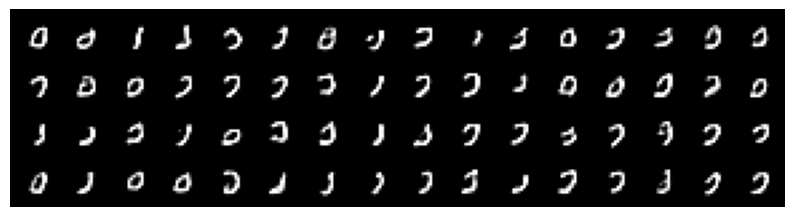

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


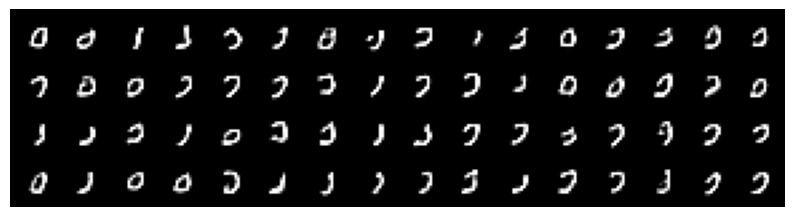

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


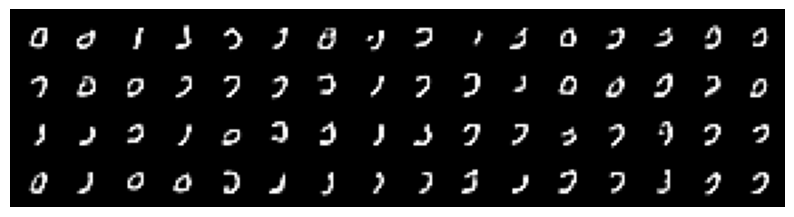

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


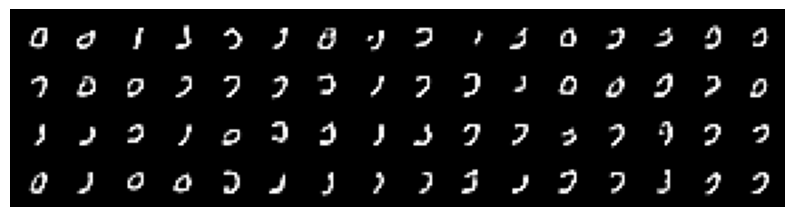

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


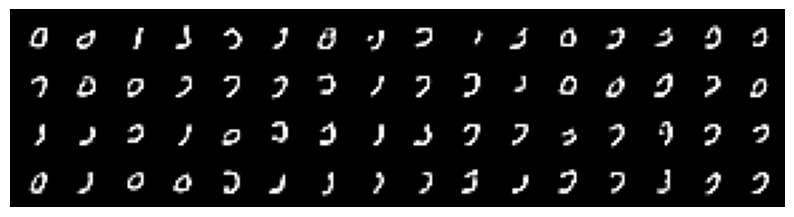

/home/fe/goettlich/miniconda3/envs/mlp/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


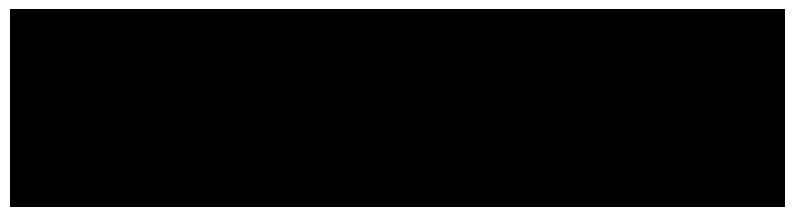

In [3]:
import torch
from simple_unet import SmallMultiDiffstepConditionedUNet
from denoising_diffusion_pytorch import Unet
from tqdm.notebook import tqdm

# model = SmallMultiDiffstepConditionedUNet(n_channels=1, n_diffsteps=T, initial_layer=16, multiplications=[1,2,4,8])
# model = Unet(dim=IMG_SIZE, channels=1, self_condition=False)
model = MinimalConditionedUNet(n_channels=1, img_size=IMG_SIZE, initial_layer=INITIAL_LAYER, n_diffsteps=T).to(device)
model.load_state_dict(torch.load("ddpm_minimal.ckpt"))
model.eval()
model.to(device)

# generate 64 samples
with torch.no_grad():
    
    xt = torch.randn(size=(64,1,IMG_SIZE,IMG_SIZE)).to(device)

    for t in tqdm(reversed(range(T)), desc="Sampling", total=T):

        z = torch.randn(size=xt.shape).to(device) if t>1 else torch.zeros_like(xt)
        
        sigma_t = (1-alpha_cumprod[t-1])/(1-alpha_cumprod[t]) * beta_schedule[t]
        t_tensor = torch.tensor([t]*xt.shape[0])

        xt = 1/torch.sqrt(alpha_schedule[t]) * (xt - (1-alpha_schedule[t])/torch.sqrt(1-alpha_cumprod[t]) * model(xt.to(device),t_tensor.to(device))) + sigma_t * z
        xt.clamp_(-1.,1.)

        if t%50 == 0:
            img = make_grid(xt, nrow=16)
            # img = make_grid((xt-xt.min())/(xt.max()-xt.min()), nrow=16)
            # print(f"max = {img.max()}, min = {img.min()}")
            plt.figure(figsize=(10,4))
            plt.imshow(img.permute(1, 2, 0).cpu())
            plt.axis('off')
            plt.show()

# TODO

* training probably fails
* if i pass t to every layer, it even stops after 8 epochs (vs. 100 epochs without) and is really bad
* gotta take a time-conditioned reference UNet


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

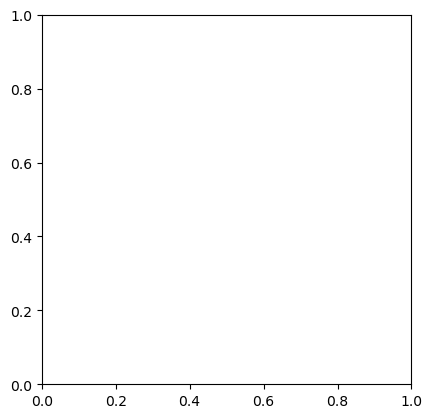

In [4]:
# plt.imshow(img.permute(1, 2, 0)>0.5)
img = img.permute(1, 2, 0)
larger = img>0.5
smaller = img<=0.5
img[larger] = torch.zeros_like(img[larger])
img[smaller] = torch.ones_like(img[smaller])
plt.imshow(img)
